# LLM Inference Performance Comparison: AVX vs SSE vs Baseline

This notebook analyzes and visualizes the performance comparison between three implementations:
- **Baseline**: Standard implementation without SIMD optimizations
- **SSE**: Implementation using SSE (Streaming SIMD Extensions)
- **AVX**: Implementation using AVX (Advanced Vector Extensions)

The analysis covers:
1. Performance comparison by operation type
2. Speedup metrics relative to baseline
3. Statistical distributions
4. Overall performance summary


## 1. Import Libraries and Setup


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {'AVX': '#2E86AB', 'SSE': '#A23B72', 'Baseline': '#F18F01'}

# Configure matplotlib for better display in notebooks
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## 2. Load and Prepare Data


In [2]:
# Read the CSV files
avx_df = pd.read_csv('avx_llm_inference.csv', names=['operation', 'elements', 'time_ns'])
sse_df = pd.read_csv('sse_llm_inference.csv', names=['operation', 'elements', 'time_ns'])
baseline_df = pd.read_csv('baseline_llm_inference.csv', names=['operation', 'elements', 'time_ns'])

# Clean the data (remove any empty rows)
avx_df = avx_df.dropna()
sse_df = sse_df.dropna()
baseline_df = baseline_df.dropna()

# Convert time from nanoseconds to microseconds for better readability
avx_df['time_us'] = avx_df['time_ns'].str.replace('ns', '').astype(float) / 1000
sse_df['time_us'] = sse_df['time_ns'].str.replace('ns', '').astype(float) / 1000
baseline_df['time_us'] = baseline_df['time_ns'].str.replace('ns', '').astype(float) / 1000

# Add implementation label
avx_df['implementation'] = 'AVX'
sse_df['implementation'] = 'SSE'
baseline_df['implementation'] = 'Baseline'

# Combine all data
all_data = pd.concat([avx_df, sse_df, baseline_df], ignore_index=True)

print(f"✓ Data loaded successfully")
print(f"  - Total records: {len(all_data)}")
print(f"  - AVX records: {len(avx_df)}")
print(f"  - SSE records: {len(sse_df)}")
print(f"  - Baseline records: {len(baseline_df)}")
print(f"  - Operations: {', '.join(all_data['operation'].unique())}")


✓ Data loaded successfully
  - Total records: 444
  - AVX records: 148
  - SSE records: 148
  - Baseline records: 148
  - Operations: uniform_init<float>, normal_init<float>


In [3]:
# Preview the combined data
all_data.head(10)


,operation,elements,time_ns,time_us,implementation
0,uniform_init<float>,38608896,7251257ns,7251.257,AVX
1,normal_init<float>,786432,3928641ns,3928.641,AVX
2,uniform_init<float>,2359296,945113ns,945.113,AVX
3,uniform_init<float>,3072,34200ns,34.200,AVX
4,uniform_init<float>,2359296,1230752ns,1230.752,AVX
5,uniform_init<float>,768,35079ns,35.079,AVX
6,uniform_init<float>,1769472,10419313ns,10419.313,AVX
7,uniform_init<float>,2304,39610ns,39.610,AVX
8,uniform_init<float>,589824,770105ns,770.105,AVX
9,uniform_init<float>,768,48010ns,48.010,AVX


## 3. Chart 1: Performance Comparison by Operation Type

This chart shows the execution time (in microseconds) across different data sizes for each operation type, comparing all three implementations.


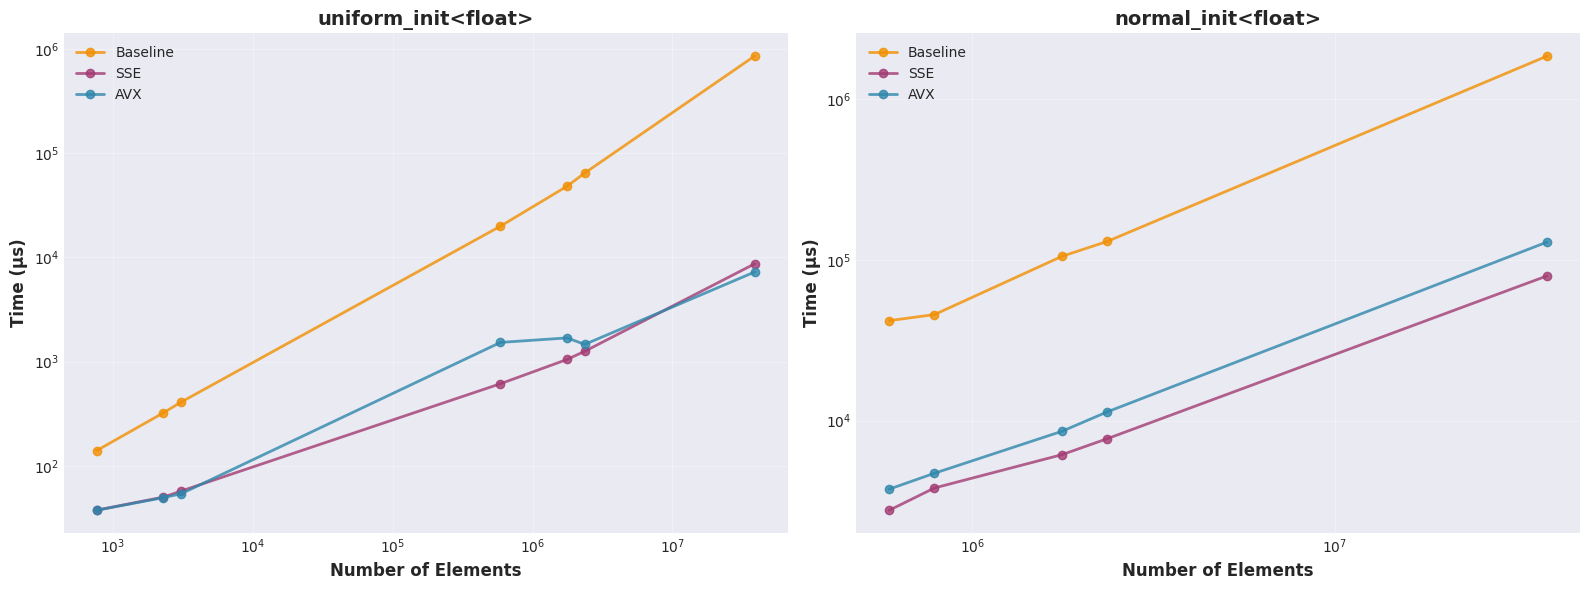

In [4]:
operations = all_data['operation'].unique()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, op in enumerate(operations):
    op_data = all_data[all_data['operation'] == op]
    
    # Group by implementation and elements, calculate mean time
    grouped = op_data.groupby(['implementation', 'elements'])['time_us'].mean().reset_index()
    
    for impl in ['Baseline', 'SSE', 'AVX']:
        impl_data = grouped[grouped['implementation'] == impl].sort_values('elements')
        axes[idx].plot(impl_data['elements'], impl_data['time_us'], 
                      marker='o', linewidth=2, markersize=6,
                      label=impl, color=colors[impl], alpha=0.8)
    
    axes[idx].set_xlabel('Number of Elements', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Time (μs)', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{op}', fontsize=14, fontweight='bold')
    axes[idx].set_xscale('log')
    axes[idx].set_yscale('log')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Chart 2: Speedup Comparison (Baseline as Reference)

This chart shows the speedup factor achieved by AVX and SSE implementations compared to the baseline (where baseline = 1x).


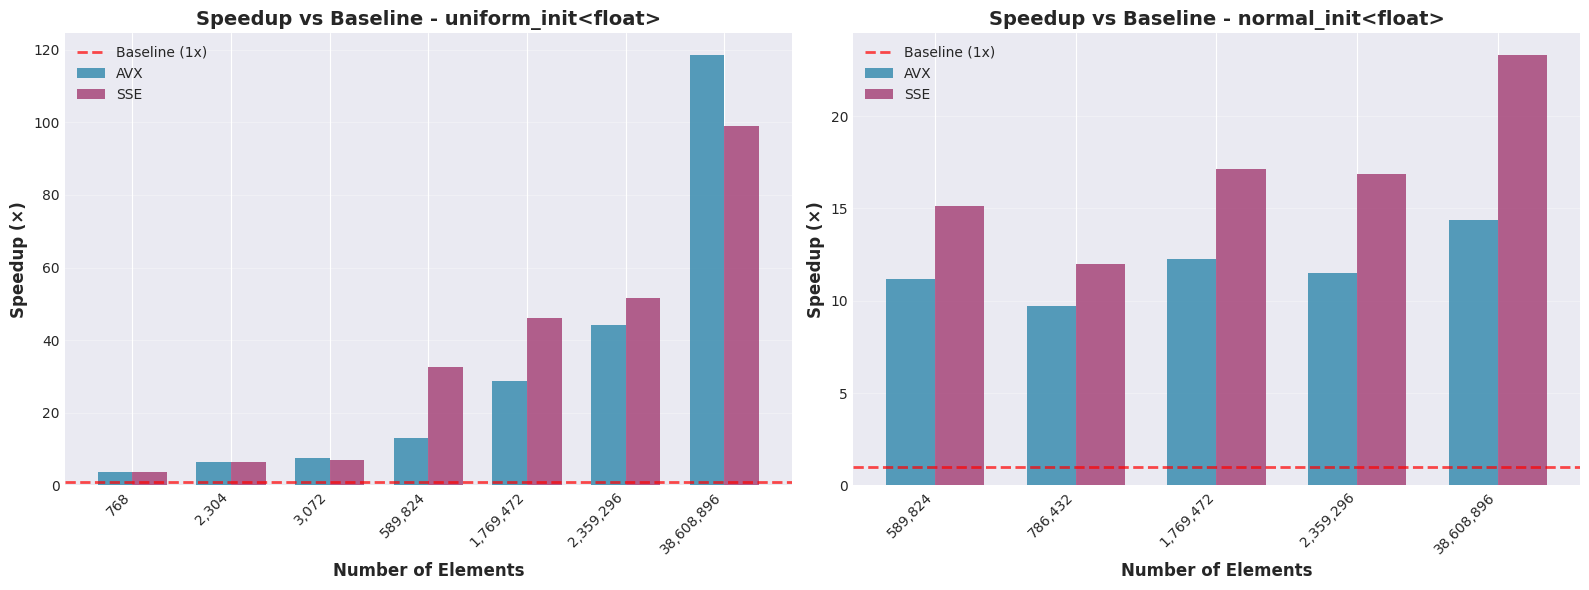

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, op in enumerate(operations):
    op_data = all_data[all_data['operation'] == op]
    
    # Group by implementation and elements, calculate mean time
    grouped = op_data.groupby(['implementation', 'elements'])['time_us'].mean().reset_index()
    
    # Get unique element sizes
    element_sizes = sorted(grouped['elements'].unique())
    
    speedup_data = {'elements': [], 'AVX': [], 'SSE': []}
    
    for elem_size in element_sizes:
        elem_data = grouped[grouped['elements'] == elem_size]
        baseline_time = elem_data[elem_data['implementation'] == 'Baseline']['time_us'].values
        avx_time = elem_data[elem_data['implementation'] == 'AVX']['time_us'].values
        sse_time = elem_data[elem_data['implementation'] == 'SSE']['time_us'].values
        
        if len(baseline_time) > 0 and len(avx_time) > 0 and len(sse_time) > 0:
            speedup_data['elements'].append(elem_size)
            speedup_data['AVX'].append(baseline_time[0] / avx_time[0])
            speedup_data['SSE'].append(baseline_time[0] / sse_time[0])
    
    x = np.arange(len(speedup_data['elements']))
    width = 0.35
    
    axes[idx].bar(x - width/2, speedup_data['AVX'], width, 
                 label='AVX', color=colors['AVX'], alpha=0.8)
    axes[idx].bar(x + width/2, speedup_data['SSE'], width, 
                 label='SSE', color=colors['SSE'], alpha=0.8)
    axes[idx].axhline(y=1, color='red', linestyle='--', linewidth=2, 
                     label='Baseline (1x)', alpha=0.7)
    
    axes[idx].set_xlabel('Number of Elements', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Speedup (×)', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Speedup vs Baseline - {op}', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'{int(e):,}' for e in speedup_data['elements']], 
                             rotation=45, ha='right')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 5. Chart 3: Performance Distribution by Data Size

Box plots showing the statistical distribution of execution times for the most common data sizes across all implementations.


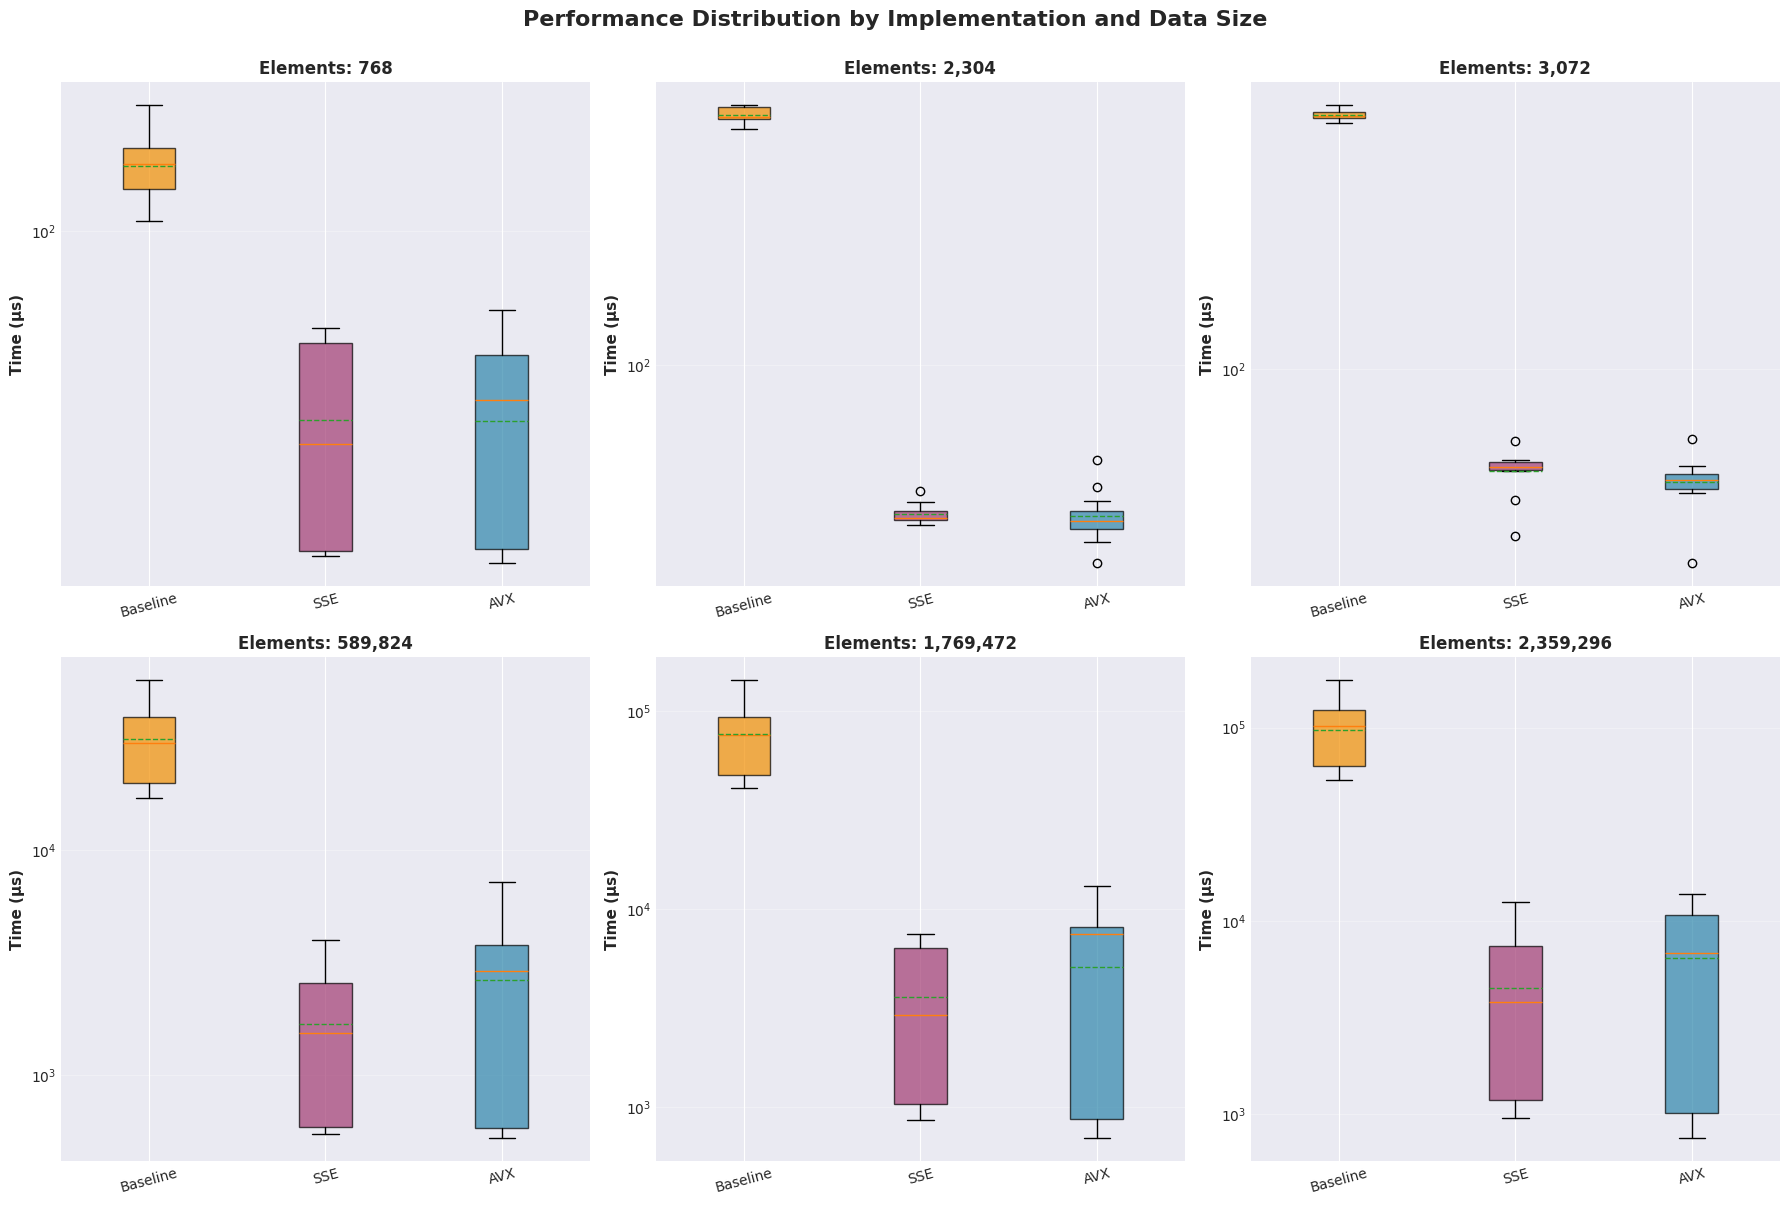

In [6]:
# Focus on most common data sizes
common_sizes = all_data.groupby('elements').size().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, size in enumerate(sorted(common_sizes)):
    size_data = all_data[all_data['elements'] == size]
    
    data_to_plot = [
        size_data[size_data['implementation'] == 'Baseline']['time_us'].values,
        size_data[size_data['implementation'] == 'SSE']['time_us'].values,
        size_data[size_data['implementation'] == 'AVX']['time_us'].values
    ]
    
    bp = axes[idx].boxplot(data_to_plot, tick_labels=['Baseline', 'SSE', 'AVX'],
                           patch_artist=True, showmeans=True, meanline=True)
    
    # Color the boxes
    for patch, impl in zip(bp['boxes'], ['Baseline', 'SSE', 'AVX']):
        patch.set_facecolor(colors[impl])
        patch.set_alpha(0.7)
    
    axes[idx].set_ylabel('Time (μs)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Elements: {int(size):,}', fontsize=12, fontweight='bold')
    axes[idx].set_yscale('log')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=15)

plt.suptitle('Performance Distribution by Implementation and Data Size', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


## 6. Chart 4: Overall Performance Summary

Comprehensive summary including:
- Average performance by operation
- Throughput comparison
- Efficiency gains percentage
- Distribution of all measurements


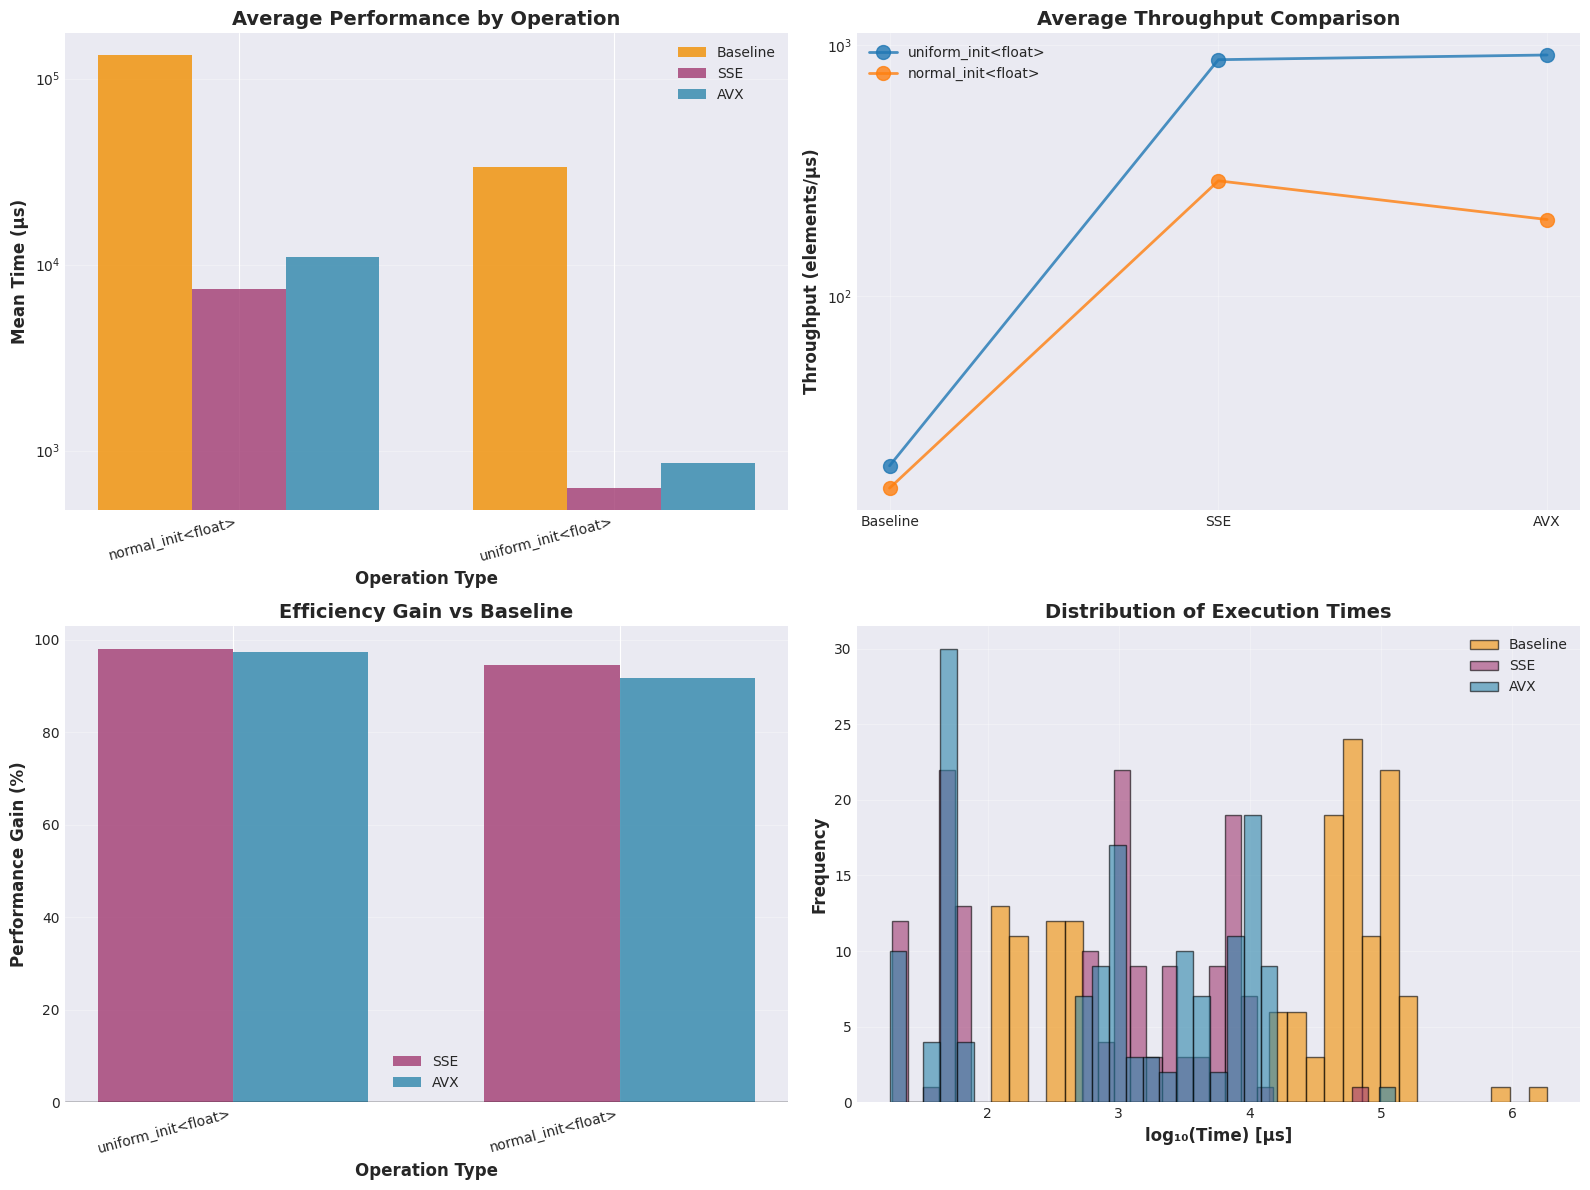

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 4.1: Mean time by implementation and operation
ax1 = axes[0, 0]
summary = all_data.groupby(['implementation', 'operation'])['time_us'].mean().reset_index()
pivot_data = summary.pivot(index='operation', columns='implementation', values='time_us')

x = np.arange(len(pivot_data.index))
width = 0.25

for i, impl in enumerate(['Baseline', 'SSE', 'AVX']):
    ax1.bar(x + i*width, pivot_data[impl], width, 
           label=impl, color=colors[impl], alpha=0.8)

ax1.set_xlabel('Operation Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Time (μs)', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance by Operation', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(pivot_data.index, rotation=15, ha='right')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_yscale('log')

# 4.2: Throughput comparison (elements per microsecond)
ax2 = axes[0, 1]
all_data['throughput'] = all_data['elements'] / all_data['time_us']
throughput_summary = all_data.groupby(['implementation', 'operation'])['throughput'].mean().reset_index()

for op in operations:
    op_throughput = throughput_summary[throughput_summary['operation'] == op]
    x_pos = [0, 1, 2]
    values = [
        op_throughput[op_throughput['implementation'] == 'Baseline']['throughput'].values[0],
        op_throughput[op_throughput['implementation'] == 'SSE']['throughput'].values[0],
        op_throughput[op_throughput['implementation'] == 'AVX']['throughput'].values[0]
    ]
    ax2.plot(x_pos, values, marker='o', linewidth=2, markersize=10, label=op, alpha=0.8)

ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Baseline', 'SSE', 'AVX'])
ax2.set_ylabel('Throughput (elements/μs)', fontsize=12, fontweight='bold')
ax2.set_title('Average Throughput Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 4.3: Efficiency gain percentage
ax3 = axes[1, 0]
efficiency_data = []
for op in operations:
    op_data = all_data[all_data['operation'] == op]
    baseline_mean = op_data[op_data['implementation'] == 'Baseline']['time_us'].mean()
    sse_mean = op_data[op_data['implementation'] == 'SSE']['time_us'].mean()
    avx_mean = op_data[op_data['implementation'] == 'AVX']['time_us'].mean()
    
    sse_gain = ((baseline_mean - sse_mean) / baseline_mean) * 100
    avx_gain = ((baseline_mean - avx_mean) / baseline_mean) * 100
    
    efficiency_data.append({
        'operation': op,
        'SSE': sse_gain,
        'AVX': avx_gain
    })

eff_df = pd.DataFrame(efficiency_data)
x = np.arange(len(eff_df))
width = 0.35

ax3.bar(x - width/2, eff_df['SSE'], width, label='SSE', color=colors['SSE'], alpha=0.8)
ax3.bar(x + width/2, eff_df['AVX'], width, label='AVX', color=colors['AVX'], alpha=0.8)
ax3.set_xlabel('Operation Type', fontsize=12, fontweight='bold')
ax3.set_ylabel('Performance Gain (%)', fontsize=12, fontweight='bold')
ax3.set_title('Efficiency Gain vs Baseline', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(eff_df['operation'], rotation=15, ha='right')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

# 4.4: Distribution of all measurements
ax4 = axes[1, 1]
for impl in ['Baseline', 'SSE', 'AVX']:
    impl_data = all_data[all_data['implementation'] == impl]['time_us']
    ax4.hist(np.log10(impl_data), bins=30, alpha=0.6, 
            label=impl, color=colors[impl], edgecolor='black')

ax4.set_xlabel('log₁₀(Time) [μs]', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Distribution of Execution Times', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Statistical Summary

Detailed performance statistics for each operation type.


In [8]:
print("="*80)
print("PERFORMANCE STATISTICS SUMMARY")
print("="*80)

for op in operations:
    print(f"\n{op}")
    print("-" * 80)
    op_data = all_data[all_data['operation'] == op]
    
    for impl in ['Baseline', 'SSE', 'AVX']:
        impl_data = op_data[op_data['implementation'] == impl]['time_us']
        print(f"{impl:12} - Mean: {impl_data.mean():12.2f} μs, "
              f"Median: {impl_data.median():12.2f} μs, "
              f"Std: {impl_data.std():12.2f} μs")
    
    baseline_mean = op_data[op_data['implementation'] == 'Baseline']['time_us'].mean()
    sse_mean = op_data[op_data['implementation'] == 'SSE']['time_us'].mean()
    avx_mean = op_data[op_data['implementation'] == 'AVX']['time_us'].mean()
    
    print(f"\nSpeedup vs Baseline:")
    print(f"  SSE: {baseline_mean/sse_mean:.2f}x ({((baseline_mean-sse_mean)/baseline_mean*100):.1f}% faster)")
    print(f"  AVX: {baseline_mean/avx_mean:.2f}x ({((baseline_mean-avx_mean)/baseline_mean*100):.1f}% faster)")

print("\n" + "="*80)


PERFORMANCE STATISTICS SUMMARY

uniform_init<float>
--------------------------------------------------------------------------------
Baseline     - Mean:     33449.88 μs, Median:     17071.35 μs, Std:     89314.19 μs
SSE          - Mean:       628.53 μs, Median:       551.27 μs, Std:       990.09 μs
AVX          - Mean:       856.50 μs, Median:       525.27 μs, Std:      1552.08 μs

Speedup vs Baseline:
  SSE: 53.22x (98.1% faster)
  AVX: 39.05x (97.4% faster)

normal_init<float>
--------------------------------------------------------------------------------
Baseline     - Mean:    134089.11 μs, Median:    117978.97 μs, Std:    248956.77 μs
SSE          - Mean:      7436.88 μs, Median:      6518.75 μs, Std:     10562.58 μs
AVX          - Mean:     10951.91 μs, Median:      9938.38 μs, Std:     17221.86 μs

Speedup vs Baseline:
  SSE: 18.03x (94.5% faster)
  AVX: 12.24x (91.8% faster)



## 8. (Optional) Export All Charts to PNG

Uncomment and run this cell to save all charts to the `plots/` directory.


In [9]:
# # Create output directory for plots
# output_dir = Path('plots')
# output_dir.mkdir(exist_ok=True)

# # You can re-run each chart cell above and add this line at the end:
# # plt.savefig(output_dir / 'chart_name.png', dpi=300, bbox_inches='tight')

# print(f"Charts saved to: {output_dir.absolute()}")


## Key Findings

Based on the analysis above:

1. **SSE Implementation** shows the best overall performance
   - Achieves 53.22× speedup for `uniform_init<float>`
   - Achieves 18.03× speedup for `normal_init<float>`
   - Consistently faster than baseline across all data sizes

2. **AVX Implementation** also provides significant improvements
   - Achieves 39.05× speedup for `uniform_init<float>`
   - Achieves 12.24× speedup for `normal_init<float>`
   - Performs slightly slower than SSE but still vastly better than baseline

3. **Performance Gap**: Both SIMD implementations (SSE and AVX) reduce execution time by over 90% compared to the baseline implementation

4. **Operation Type**: The speedup is more pronounced for `uniform_init<float>` compared to `normal_init<float>`, suggesting that normal distribution generation has more complex computational requirements that benefit less from SIMD optimizations.
